In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

def linear_pred(li_in):
    li = li_in.copy()
    
    li_arr = np.asarray(li)
    li_arr = np.reshape(li_arr, (len(li), 1))
    x_arr = np.arange(len(li))
    x_arr = np.reshape(x_arr, (len(li), 1))

    regr = linear_model.LinearRegression()
    regr.fit(x_arr, li_arr)
    pred = regr.predict(len(li))
    return pred[0, 0]


def plot_each_w_trend(choose_feature, w_list):
    wListTranspose = numpy.zeros(shape=(len(choose_feature), len(w_list)))

    for feature in range(0, len(choose_feature)):
        if choose_feature[feature]:
            for trial in range(0, len(w_list)):
                wListTranspose[feature][trial] = w_list[trial][feature]
            
        print(wListTranspose)

In [3]:
import sys

def next_state(state, action, action_level):
    next_state = state.copy()
    if (action > 2*action_level) or action < 0:
        print("action = ", action)
        sys.exit("error, action undefined! nxt")

    if action >= 1 and action <= action_level:
        # then buy
        
        if state['HandCash'] > 0:
            next_state['HandCash'] = state['HandCash']*(1 - action/action_level)
            next_state['NumStock'] = state['NumStock'] + \
                                     (state['HandCash']/state['StockPrice'])*(action/action_level)

    elif action >= (action_level + 1) and action <= (action_level + action_level) :
        # then sell
        
        if state['NumStock'] > 0:
            next_state['NumStock'] = state['NumStock']*(1 - (action-action_level)/action_level)
            next_state['HandCash'] = state['HandCash'] + \
                                     (state['StockPrice']*state['NumStock'])*((action-action_level)/action_level)
    
    return next_state


def reward(state, init_invest):
    return (state['NumStock']*state['StockPrice'] + state['HandCash']) - init_invest

def my_reward(curr, last):
    return (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
       
def penalty_reward(curr, last):
    penalty_multiplier = 10
    k = (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
    #print('k = ', curr['NumStock'], ' * ', curr['StockPrice'], ' + ',  curr['HandCash'], ' - ', last['NumStock'], ' * ', 
          #last['StockPrice'], ' + ', last['HandCash'])
    if k < 0:
        k = k*penalty_multiplier
    return k


def benefit_reward(curr, last):
    penalty_multiplier = 3000
    benefit_multiplier = 1000
    k = (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - \
           (last['NumStock']*last['StockPrice'] + last['HandCash'])
    j = k / float(last['NumStock']*last['StockPrice'] + last['HandCash'])
    if j <= -0.01:
        r = j*penalty_multiplier
    elif -0.03 < j <= -0.01:
        r = -7
    elif -0.01< j < 0.03:
        r = -2
    else:
        r = j*benefit_multiplier
    return r

def benefit_reward2(curr, last):
    penalty_multiplier = 3000
    benefit_multiplier = 1000
    k = (curr['NumStock']*curr['StockPrice'] + curr['HandCash']) - 10000#\
           #(last['NumStock']*last['StockPrice'] + last['HandCash'])
    j = k / 10000#float(last['NumStock']*last['StockPrice'] + last['HandCash'])
    if j <= -0.01:
        r = j*penalty_multiplier
    elif -0.03 < j <= -0.01:
        r = -7
    elif -0.01< j < 0.03:
        r = -2
    else:
        r = j*benefit_multiplier
    return r

In [4]:
import math
# feature 1 : indicate the difference of #stock after the action from the state
# state is a dictionary with 3 elements
def feature_1(state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f1")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (state['HandCash']/state['StockPrice'])*(action/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = (-1)*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_1.max:
            feature_1.max = tmp
            return 1
        elif tmp < feature_1.min:
            feature_1.min = tmp
            return 0
        else:
            return (tmp - feature_1.min) / (feature_1.max - feature_1.min)

    #elif action == (2*action_level + 1): # hold
    elif action == 0: # hold
        return 0
feature_1.max = 1
feature_1.min = 0
    

# feature 2 : indicate the difference of #Cash in Hand after the action from the state
def feature_2(state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f2")
        
    elif action >= 1 and action <= action_level: # buy
        tmp = (-1)*state['HandCash'] * (action/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    elif action >= (action_level + 1) and action <= (action_level + action_level) : # sell
        tmp = state['StockPrice']*state['NumStock'] * ((action-action_level)/action_level)
        if tmp > feature_2.max:
            feature_2.max = tmp
            return 1
        elif tmp < feature_2.min:
            feature_2.min = tmp
            return 0
        else:
            return (tmp - feature_2.min) / (feature_2.max - feature_2.min)

    #elif action == (2*action_level + 1): # hold
    elif action == 0: # hold
        return 0
feature_2.max = 1
feature_2.min = 0

    
# linear_based_rwd    
def feature_3(price_list, state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f3")
    
    #next_price = linear_pred(price_list)
    next_price = sum(price_list)/len(price_list)
    
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
        
    tmp = my_reward(next_s, state)
    if tmp > feature_3.max:
        feature_3.max = tmp
        return 1
    elif tmp < feature_3.min:
        feature_3.min = tmp
        return 0
    else:
        return (tmp - feature_3.min) / (feature_3.max - feature_3.min)
    
    #return my_reward(next_s, state)/100
feature_3.max = 1
feature_3.min = 0


def feature_4(price_list, state, action, action_level):
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! f4")
    
    #next_price = linear_pred(price_list)
    next_price = sum(price_list)/len(price_list)
    
    next_s = next_state(state, action, action_level)
    next_s['StockPrice'] = next_price
    
    if next_price >= state['StockPrice']:
        best_action = action_level # buy with all cash u have
    else:
        best_action = 2*action_level # sell all stocks u have
    best_next_s = next_state(state, best_action, action_level)
    best_next_s['StockPrice'] = next_price
    
    
    tmp = my_reward(best_next_s, state) - my_reward(next_s, state)
    #print("action, tmp = ", action, tmp)
    if tmp > feature_4.max:
        feature_4.max = tmp
        return 1
    elif tmp < feature_4.min:
        feature_4.min = tmp
        return 0
    else:
        return (tmp - feature_4.min) / (feature_4.max - feature_4.min)
feature_4.max = 1
feature_4.min = 0

def feature_5_conti(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    sinter = inter/100 # scaled inter
    if((k_yestd > d_yestd and k_today < d_today and inter > 50) or \
       (k_yestd < d_yestd and k_today > d_today and inter < 50)):
        # saction= sell all:1, sell:1~0.5, hold:0.5, buy:0.5~0, buy all:0
        # the diff btw saction & sinter(i.e. inter/100) : smaller is better(then return larger value)
        
        if(action <= action_level):
            saction = (action_level - action)/(2*action_level) # scaled action
        else:
            saction = action/(2*action_level)
            
        return 1-abs(sinter-saction)
        
    else: # best to hold
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
# from feature_6_my  
def feature_5_dis(k_today, d_today, k_yestd, d_yestd, action, action_level):
    inter = (k_yestd+d_yestd+k_today+d_today)/4
    if(k_yestd < d_yestd and k_today > d_today and inter < 30): # buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
       
    elif(k_yestd > d_yestd and k_today < d_today and inter > 70): # sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
    else:
        if(action <= action_level): # hold
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    
def psy(price_list):
    n = 0
    for i in range(1, len(price_list)):
        if price_list[i] > price_list[i-1]:
            n += 1
    return (n/float(len(price_list) - 1))*100


def feature_6_original(price_list,action,action_level):
    psy_num = psy(price_list)
    if(psy_num <= 25): # market oversell we can buy
        if(action <= action_level):
            return (action + action_level + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action - action_level)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
    if(25 < psy_num < 75):#hold to observe situation
        if(action <= action_level):
            return 2*(action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return 2*(2*action_level - action + 1)/float(2*action_level + 1)
        else:
            return 1
    if(psy_num >= 75):#market overbuy we can sell
        if(action <= action_level):
            return (action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action + 1)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
        
        
def feature_6_dis(price_list, action, action_level):
    psy_num = psy(price_list)
    if(psy_num <= 25): # market oversell we can buy
        if(action <= action_level):
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(2*action_level)
        
    if(25 < psy_num < 75):#hold to observe situation
        if(action <= action_level):
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
        
    if(psy_num >= 75):#market overbuy we can sell
        if(action <= action_level):
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            return (action)/float(2*action_level)
        
def feature_6_conti(price_list, action, action_level):
    psy_num = psy(price_list)
    spsy_num = psy_num/100

    if(action <= action_level):
        saction = (action_level - action)/(2*action_level) # scaled action
    else:
        saction = action/(2*action_level)
            
    return 1-abs(spsy_num-saction)


def feature_7(price_list, state, action, action_level):
    if(action > 2*action_level) or action < 0:
        sys.exit("error, action undefined!")
        
    price_avg = sum(price_list) / float(len(price_list))
    #print('price_avg = ', price_avg)
    
    #stock price is higher than avg_price means the stock is going up
    if price_avg <= state['StockPrice']:
    #if price_avg <= math.floor(state['StockPrice']):
        price_trend = 1
    else:
        price_trend = 0
    #print('price_trend= ', price_trend)
    
    #stock is going up, we should buy
    if price_trend == 1:
        if(action <= action_level):
            #print('in1')
            return (action + action_level)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            #print('in2')
            return (2*action_level - action)/float(2*action_level)
    #stock is going down, sell
    elif price_trend == 0:
        if(action <= action_level):
            #print('in3')
            return (action_level - action)/float(2*action_level)
        elif(action_level < action <= 2*action_level):
            #print('in4')
            return (action)/float(2*action_level)
        
def list_rev_count(inlist):
    ret = 0
    for i in range(2, len(inlist)):
        if (inlist[i] - inlist[i-1]) * (inlist[i-1] - inlist[i-2]) < 0:
            ret = ret + 1
    return ret

def feature_8_vari(price_list, action, action_level):
    if(action > 2*action_level) or action < 0:
        sys.exit("error, action undefined!")
    
    revcount = list_rev_count(price_list)
    
    if revcount > len(price_list) / 3:  # best to hold
        if(action <= action_level): 
            return (action_level - action)/float(action_level)
        elif(action_level < action <= 2*action_level):
            return (2*action_level - action)/float(action_level)
    else:
        return 0
    
def open_price_trend(state, last_state):
    # op higher than yesterday's high -> trend is up
    op_trend = 0.5
    if(state['OpenPrice'] > last_state['HighPrice']):
        op_trend += 0.2
        # up over 5% -> trend is up
        if((state['OpenPrice'] - last_state['StockPrice'])/float(last_state['StockPrice']) > 0.05):
            op_trend += 0.3
        
    # op is lower than yesterday's low -> trend is down
    if(state['OpenPrice'] < last_state['LowPrice']):
        op_trend -= 0.2
        # down over 5% -> trend is down
        if((state['OpenPrice'] - last_state['StockPrice'])/float(last_state['StockPrice']) < -0.05):
            op_trend -= 0.3
    return op_trend

def feature_9_open(version, optrend_1, optrend_2, optrend_3, optrend_4, optrend_5, action, action_level):
    if version == 1:
        optrend = optrend_1
    elif version == 2:
        trend_3day = float(optrend_1 + optrend2 + optrend_3)/float(3)
        trend = trend_3day*(0.33) + optrend_1*(0.67)
    elif version == 3:
        trend_5day = float(optrend_1+optrend_2+optrend_3+optrend_4+optrend_5)/float(5)
        trend_3day = float(optrend_1+optrend_2+optrend_3)/float(3)
        trend = trend_5day*(0.2)+trend_3day*(0.3)+optrend_1*(0.5)
    else:
        sys.exit("error, version undefined! feature_9_open")
    
    #suggest to buy
    if(trend > 0.5):
        if(action <= action_level):
            return (action + action_level + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action - action_level)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
    
    #keep observe
    if(trend == 0.5):
        if(action <= action_level):
            return 2*(action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return 2*(2*action_level - action + 1)/float(2*action_level + 1)
        else:
            return 1
    #suggest to sell
    if(trend < 0.5):
        if(action <= action_level):
            return (action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action + 1)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
        
        
def RSI(price_list):
    up = 0 #increase mount
    dn = 0 #decrease mount
    for i in range(1, len(price_list)):
        if price_list[i] > price_list[i-1]:
            up += price_list[i] - price_list[i-1]
        else:
            dn += price_list[i-1] - price_list[i]
    if (up+dn) == 0:
        return 0;
    else:
        return (up/float(up + dn))*100

def feature_10(rsi_6_cur, rsi_12_cur, rsi_6_last, rsi_12_last, action, action_level):
    if rsi_6_cur > 80: # overbuy so we sell out
        if(action <= action_level):
            return (action_level - action + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action + 1)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)
    elif 50 < rsi_6_cur <= 80:#stock price may go up
        if (rsi_6_last < rsi_12_last) and (rsi_6_cur > rsi_12_cur):#gold cross we can buy
            if(action <= action_level):
                return (action + action_level + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return (action - action_level)/float(2*action_level + 1)
            else:
                return (action_level+1)/float(2*action_level + 1)
        elif (rsi_6_last > rsi_12_last) and (rsi_6_cur < rsi_12_cur):#death cross we can sell
            if(action <= action_level):
                return (action_level - action + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return (action + 1)/float(2*action_level + 1)
            else:
                return (action_level+1)/float(2*action_level + 1)
        else:#keep observe
            if(action <= action_level):
                return 2*(action_level - action + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return 2*(2*action_level - action + 1)/float(2*action_level + 1)
            else:
                return 1
    elif 20 < rsi_6_cur <= 50:#stock price may go down
        if (rsi_6_last < rsi_12_last) and (rsi_6_cur > rsi_12_cur):#gold cross we can buy
            if(action <= action_level):
                return (action + action_level + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return (action - action_level)/float(2*action_level + 1)
            else:
                return (action_level+1)/float(2*action_level + 1)
        elif (rsi_6_last > rsi_12_last) and (rsi_6_cur < rsi_12_cur):#death cross we can sell
            if(action <= action_level):
                return (action_level - action + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return (action + 1)/float(2*action_level + 1)
            else:
                return (action_level+1)/float(2*action_level + 1)
        else:#keep observe
            if(action <= action_level):
                return 2*(action_level - action + 1)/float(2*action_level + 1)
            elif(action_level < action <= 2*action_level):
                return 2*(2*action_level - action + 1)/float(2*action_level + 1)
            else:
                return 1
    else:#over sell so we buy in 
        if(action <= action_level):
            return (action + action_level + 1)/float(2*action_level + 1)
        elif(action_level < action <= 2*action_level):
            return (action - action_level)/float(2*action_level + 1)
        else:
            return (action_level+1)/float(2*action_level + 1)

Note: feature3 and feature4 is hard code with the reward function : my_reward  
  
feature1: 做了某action後，portfolio中股票的變化量  
feature2: 做了某action後，portfolio中現金的變化量  
feature3: 假設下個價格為線性回歸預測的結果。現在做了某action，接著價格由目前價格變為下個價格後，portfolio價值的變化量  
feature4: 假設下個價格為線性回歸預測的結果。（最佳action替portfolio增加的價值 - 某action替portfolio增加的價值）

In [5]:
from random import randint

def Q_value(k_today, d_today, k_yestd, d_yestd, 
            price_list, 
            f9version, optrend_1, optrend_2, optrend_3, optrend_4, optrend_5,
            rsi_6_curr, rsi_6_last, rsi_12_curr, rsi_12_last,
            state, action, w, action_level, choose_feature):
    
    """
    :param price_list: the input of feature_3 and feature_4
    :param k_today, d_today, k_yestd, d_yestd: the input of feature_5
    :return: num
    """
            
    if (action > 2*action_level) or action < 0:
        sys.exit("error, action undefined! Q")
        
    ret = 0
    
    if(choose_feature[0]):
        ret = ret + w[0]*feature_1(state, action, action_level)
    if(choose_feature[1]):
        ret = ret + w[1]*feature_2(state, action, action_level)
    if(choose_feature[2]):
        ret = ret + w[2]*feature_3(price_list, state, action, action_level)
    if(choose_feature[3]):
        ret = ret + w[3]*feature_4(price_list, state, action, action_level)
    if(choose_feature[4]):
        ret = ret + w[4]*feature_5(k_today, d_today, k_yestd, d_yestd, action, action_level)
    if(choose_feature[5]):
        ret = ret + w[5]*feature_6(price_list, action ,action_level)  
    if(choose_feature[6]):
        ret = ret + w[6]*feature_7(price_list, state, action, action_level) 
        #print('7', feature_7(price_list, state, action, action_level) )
    if(choose_feature[7]):
        ret = ret + w[7]*feature_8_vari(price_list, action, action_level)
    if(choose_feature[8]):
        ret = ret + w[8]*feature_9_open(f9version, optrend_1, optrend_2, optrend_3, optrend_4, optrend_5, 
                                        action, action_level)
    if(choose_feature[9]):
        ret = ret + w[9]*feature_10(rsi_6_curr, rsi_6_last, rsi_12_curr, rsi_12_last, action, action_level) 
    
    return ret
    

def V_value(k_today, d_today, k_yestd, d_yestd, price_list, 
            f9version, optrend_1,optrend_2,optrend_3,optrend_4,optrend_5,
            rsi_6_curr, rsi_6_last, rsi_12_curr, rsi_12_last,
            state, w, action_level, choose_feature):
    v = 0
    first = 1 # flag of the frist iteration
    v_act = ''
    for action in range(0, (2*action_level + 1)):
        curr_q = Q_value(k_today, d_today, k_yestd, d_yestd, price_list,
                         f9version, optrend_1,optrend_2,optrend_3,optrend_4,optrend_5,
                         rsi_6_curr, rsi_6_last, rsi_12_curr, rsi_12_last,
                         state, action, w, action_level, choose_feature)
        if first == 1:
            first = 0
            v = curr_q
            v_act = action
        elif curr_q > v:
            v = curr_q
            v_act = action
        elif curr_q == v:
            flip = randint(0, 1)
            if flip == 1:
                v = curr_q
                v_act = action
    
    # add the if statement when u want to know the effective action. don't add when u want to know the intented action
    if v == Q_value(k_today, d_today, k_yestd, d_yestd, price_list,
                         f9version, optrend_1,optrend_2,optrend_3,optrend_4,optrend_5,
                         rsi_6_curr, rsi_6_last, rsi_12_curr, rsi_12_last,
                         state, 0, w, action_level, choose_feature):
        v_act = 0
        
        
    #print("[v, v_act] = ", [v, v_act])
    return [v, v_act]

In [6]:
import math
from fractions import Fraction

class StockQLData:
    'Result data of approximated q-learning of stock price'
    
    def __init__(self, action_level, data_len, ratio_num_local, trial_range):
        self.last_reward = list()
        
        self.last_w = list()
        
        self.rwd_sum = 0
        self.avg_point_rwd = list()

        self.act_num = np.zeros(action_level*2 + 1)
        self.act_num_list = list()

        self.ratio_local_size = math.floor(data_len/ratio_num_local)
        self.tmp_local_act_num = np.zeros(action_level*2 + 1)
        self.tmp_trial_act_ratio = list()
        self.act_ratio = list() # all_trial_act_ratio
        
        self.trial_range = trial_range # for the default argumant of print_local_act_ratio
        
    def point_update_action_num(self, last_act):
        self.act_num[last_act] += 1

    
    def point_update_rwd_sum(self, state, last_state, avg_point_rwd_func):
        self.rwd_sum += avg_point_rwd_func(state, last_state) 
        
    def point_update_action_ratio(self, last_act, data_index):        
        self.tmp_local_act_num[last_act] += 1
        if (data_index+1) % self.ratio_local_size == 0:
            self.tmp_trial_act_ratio.append(self.tmp_local_act_num/self.tmp_local_act_num.sum())
            self.tmp_local_act_num.fill(0)
            
        
    def last_point(self, trial_length, state, init_invest, w, last_rwd_func):
        self.avg_point_rwd.append(self.rwd_sum/(trial_length-1)) #ignore the first reward(=0)
        self.rwd_sum = 0
        
        self.last_reward.append(last_rwd_func(state, init_invest))
        
        cp_w = w.copy()
        self.last_w.append(cp_w)

        tmp_act_num = self.act_num.copy()
        self.act_num_list.append(tmp_act_num)
        self.act_num.fill(0)
        
        if np.count_nonzero(self.tmp_local_act_num) > 0:
            self.tmp_trial_act_ratio.append(self.tmp_local_act_num/self.tmp_local_act_num.sum())
            self.tmp_local_act_num.fill(0)
        self.act_ratio.append(self.tmp_trial_act_ratio.copy())
        del self.tmp_trial_act_ratio[:] # empty the list

        
    def __act_ratio_prepare_print(self, start, end, alcnum, action_level): # the start/end trial index(can not recognize in the plot, just where data come from), actual number of local(i.e. group)
        ret = list()
        
        # initialize
        for i in range(0, alcnum):  # alcnum
            ret.append(np.zeros(action_level*2 + 1))
            
        trind = start
        lcind = 0
        for trind in range(start, end+1):
            for lcind in range(0, alcnum):
                for actind in range(0, action_level*2 + 1):
                    ret[lcind][actind] += sqld.act_ratio[trind][lcind][actind] / (end - start + 1)
        return ret

        
    # print the series with local rate ratio
    def print_local_act_ratio(self, data, action_level, start_trind=0, end_trind=None):
        if end_trind is None:
            end_trind = trial_range - 1
        
        alcnum = len(sqld.act_ratio[0]) # actual number of local(i.e. group)
        
        to_plot = self.__act_ratio_prepare_print(start_trind, end_trind, alcnum, action_level)
        
        sf, saxarr = plt.subplots(alcnum, 2, figsize=(9, 4*alcnum)) # print all local by now
        
        row_count = 0
        
        pie_labels = ["hold"]
        for i in range(1, action_level+1):
            pie_labels.append("{0} buy".format(Fraction(i, action_level)))
        for i in range(1, action_level+1):
            pie_labels.append("{0} sell".format(Fraction(i, action_level)))
            
        for lcind in range(0, alcnum): # print all local by now
            tmp_data = data.copy()
            tmp_data = tmp_data[sqld.ratio_local_size*lcind : sqld.ratio_local_size*(lcind + 1)]
            
            saxarr[row_count, 0].plot(tmp_data)
            saxarr[row_count, 0].set_title('close_price')
            
            saxarr[row_count, 1].pie(to_plot[lcind], labels=pie_labels)
            saxarr[row_count, 1].set_title('act_ratio')
            
            
            row_count += 1
        

In [7]:
def valid_year_month(year, month, add_month):
    #if add_month > 12:
        #print('Error, valid_year_month can not handle add_month which is > 12')
    ret_year = year
    ret_month = month
    
    ret_month += add_month
    if ret_month > 12:
        while True:
            ret_year += 1
            ret_month = ret_month - 12
            if ret_month <= 12:
                break
        
    return [ret_year, ret_month]

##### lists of data in each folder: copy and paste into the cell below
* ./input/  
inputFolderFormat = "./input/{0}"
inputCsvList = ['QCOM.csv', 'GOOG.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
           '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', '^SSEC.csv', 
           'NSU.DE_10_5_5.csv', 'DAI.DE_10_5_5.csv', 'BMW.DE_10_5_5.csv', 
           '0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', 
           '2330.TW.csv', '2409.TW.csv', '2454.TW.csv', '1704.TW.csv']

* ./input/2001_2010/  
inputFolderFormat = "./input/2001_2010/{0}"
inputCsvList = ['QCOM.csv', 'NOK.csv', '^DJI.csv', '^TWII.csv', 
            '^N225.csv', '^GDAXI.csv', '^IXIC.csv', '^KS11.csv', 
            '^SSEC.csv', 'NSU.DE.csv', 'DAI.DE.csv', 'BMW.DE.csv']
* ./input/fall/  
inputFolderFormat = "./input/fall/{0}"  
inputCsvList = ['1314.TW.csv', '2323.TW.csv', '2349.TW.csv', 
'2353.TW.csv', '2405.TW.csv', '2409.TW.csv', '2601.TW.csv', 
'2885.TW.csv', '2888.TW.csv', '6116.TW.csv']              

In [8]:
from random import randint
import math
import stockstats

action_level = 3
init_invest = 10000

last_rwd_func = reward
work_rwd_func = benefit_reward ## for updating w
avg_point_rwd_func = my_reward

feature_5 = feature_5_conti
feature_6 = feature_6_dis
f9version = 3
choose_feature = [False, False, False, False, False, True, True, False, True, False]

init_w = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]      
tmp_w = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

ita = 0.0035
epsilon = 0.15
gamma = 0.25

fx_num = 5
max_lookback = 14

ratio_num_local = 5
trial_range = 5

train_size = 12 # in month
test_size = 1 # in month
# YET auto
tt_count = math.floor((12*5 - train_size - test_size) / test_size) - 1  # num of trainset-testset pairs

# each dataset has to have the same data renge by now
inputFolderFormat = "./input/{0}"
inputCsvList = ['0050.TW.csv', '1216.TW.csv', '1301.TW.csv', '2002.TW.csv', '2330.TW.csv', '2409.TW.csv', '2454.TW.csv',
         '1704.TW.csv']
inputCsvList = ['0050.TW.csv']
for c in range(0, 1):
    for resource_data in inputCsvList:
    #for i in range(0, 10):
        #resource_data = '1704.TW.csv'

        # YET auto
        start_year = 2013
        start_month = 6

        test_gain = np.zeros(shape=(tt_count, 1))

        input_csv = inputFolderFormat.format(resource_data)
        data_all = pd.read_csv(input_csv)
        data_all['Date'] = pd.to_datetime(data_all['Date'], format='%Y-%m-%d')
        data_all['Close'] = data_all['Close'].fillna(method='ffill')
        data_all['Close'] = data_all['Close'].fillna(method='bfill')
        data_all['Open'] = data_all['Open'].fillna(method='ffill')
        data_all['Open'] = data_all['Open'].fillna(method='bfill')
        data_all['High'] = data_all['High'].fillna(method='ffill')
        data_all['High'] = data_all['High'].fillna(method='bfill')
        data_all['Low'] = data_all['Low'].fillna(method='ffill')
        data_all['Low'] = data_all['Low'].fillna(method='bfill')

        tmp_data_all = data_all.copy()
        StockStat = stockstats.StockDataFrame.retype(tmp_data_all)
        StockStat[['kdjk','kdjd','kdjj']]
        data_all['Kdjk'] = pd.Series(StockStat['kdjk'].tolist())
        data_all['Kdjd'] = pd.Series(StockStat['kdjd'].tolist())

        #print(tt_count)
        for tt_ind in range(0, tt_count):
            #print(tt_ind)

            # determine the close price data while training
            start_date = pd.datetime(start_year, start_month, 1)
            #bug start_date = (start_date + pd.DateOffset(days= (-1)*max_lookback)).date()
            while len(data_all.index[data_all['Date'] == start_date]) == 0:
                start_date = (start_date + pd.DateOffset(days= 1)).date()
            start_date_ind = (data_all.index[data_all['Date'] == start_date])[0]
            
            if len(data_all.index[data_all['Date'] == start_date]) != 1:
                print('ERROR, one date, several rows')
            
            start_date_ind -= max_lookback
            start_date = data_all.iloc[start_date_ind]['Date'].date()
            end_date = pd.datetime(valid_year_month(start_year, start_month, train_size)[0], 
                                   valid_year_month(start_year, start_month, train_size)[1], 1) 
            #print(start_date, end_date)
            data = data_all.loc[(start_date <= data_all['Date']) & (data_all['Date'] < end_date)]

            close = data['Close']
            close = close.tolist()
            openn = data['Open']
            openn = openn.tolist()
            high = data['High']
            high = high.tolist()
            low = data['Low']
            low = low.tolist()
            kdjk = data['Kdjk']
            kdjk = kdjk.tolist()
            kdjd = data['Kdjd']
            kdjd = kdjd.tolist()

            w = init_w.copy()
            keep_w = True  # of course, keep w while training


            #sqld = StockQLData(action_level, len(close), ratio_num_local, trial_range)


            for trial in range(0, trial_range):
                # initial state before each trial, but keep w

                state = {'NumStock': 0, 'StockPrice': close[max_lookback], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback], 'HighPrice': high[max_lookback], 'LowPrice': low[max_lookback]}
                last_state = {'NumStock': 0, 'StockPrice': close[max_lookback-1], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-1], 'HighPrice': high[max_lookback-1], 'LowPrice': low[max_lookback-1]}
                # last_state i.e. last_state_after_act
                last_state_bf_act = {'NumStock': 0, 'StockPrice': close[max_lookback-1], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-1], 'HighPrice': high[max_lookback-1], 'LowPrice': low[max_lookback-1]}  
                # last_state_bf_act i.e. last_1_state
                last_2_state = {'NumStock': 0, 'StockPrice': close[max_lookback-2], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-2], 'HighPrice': high[max_lookback-2], 'LowPrice': low[max_lookback-2]}  
                last_3_state = {'NumStock': 0, 'StockPrice': close[max_lookback-3], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-3], 'HighPrice': high[max_lookback-3], 'LowPrice': low[max_lookback-3]}  
                last_4_state = {'NumStock': 0, 'StockPrice': close[max_lookback-4], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-4], 'HighPrice': high[max_lookback-4], 'LowPrice': low[max_lookback-4]}  
                last_5_state = {'NumStock': 0, 'StockPrice': close[max_lookback-5], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-5], 'HighPrice': high[max_lookback-5], 'LowPrice': low[max_lookback-5]}  
                last_6_state = {'NumStock': 0, 'StockPrice': close[max_lookback-6], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-6], 'HighPrice': high[max_lookback-6], 'LowPrice': low[max_lookback-6]}  
                last_act = 0

                if not keep_w:
                    for i in range(0, len(w)):
                        w[i] = init_w[i] 

                for point in range(max_lookback, len(close)):

                    # new price revealed!
                    state['NumStock'] = last_state['NumStock']
                    state['HandCash'] = last_state['HandCash']
                    state['StockPrice'] = close[point]
                    state['OpenPrice'] = openn[point]
                    state['HighPrice'] = high[point]
                    state['LowPrice'] = low[point]

                    # collect data           
                    #sqld.point_update_action_num(last_act)        
                    #sqld.point_update_rwd_sum(state, last_state, avg_point_rwd_func)
                    #sqld.point_update_action_ratio(last_act, point)


                    #if point == len(close)-1:
                    #    sqld.last_point(len(close), state, init_invest, w, last_rwd_func)

                    # prepare for the arguments passed later
                    last_fx_list = close[point-fx_num:point]
                    curr_fx_list = close[point-fx_num+1:point+1]

                    # prepare for feature_10
                    rsi_6_curr = RSI(close[point-7+1:point+1])
                    rsi_6_last_1 = RSI(close[point-7:point])
                    rsi_6_last_2 = RSI(close[point-7-1:point-1])

                    rsi_12_curr = RSI(close[point-13+1:point+1])
                    rsi_12_last_1 = RSI(close[point-13:point])
                    rsi_12_last_2 = RSI(close[point-13-1:point-1])

                    # prepare for the arguments passed later
                    last_1_k = kdjk[point-1]  
                    last_1_d = kdjd[point-1] 
                    last_2_k = kdjk[point-2] 
                    last_2_d = kdjd[point-2] 
                    now_k = kdjk[point]
                    now_d = kdjd[point]


                    # prepare for feature_9_open 
                    optrend_1 = open_price_trend(state, last_state_bf_act)
                    optrend_2 = open_price_trend(last_state_bf_act,last_2_state)
                    optrend_3 = open_price_trend(last_2_state,last_3_state)
                    optrend_4 = open_price_trend(last_3_state,last_4_state)
                    optrend_5 = open_price_trend(last_4_state,last_5_state)
                    optrend_6 = open_price_trend(last_5_state,last_6_state)


                    # used in the w updating below

                    last_Q_pred = Q_value(last_1_k, last_1_d, last_2_k, last_2_d,
                                          last_fx_list, 
                                          f9version, optrend_2, optrend_3, optrend_4, optrend_5, optrend_6,
                                          rsi_6_last_1, rsi_6_last_2, rsi_12_last_1, rsi_12_last_2,
                                          last_state_bf_act, last_act, w, action_level, choose_feature)

                    target = (work_rwd_func(state, last_state) + gamma*V_value(now_k, now_d, last_1_k, last_1_d, 
                                                                              curr_fx_list,
                                                                              f9version, optrend_1, optrend_2, optrend_3, 
                                                                              optrend_4, optrend_5,
                                                                              rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                                                              state, w, action_level, choose_feature)[0])


                    if(choose_feature[0]):
                        tmp_w[0] = w[0] - ita * (last_Q_pred - target) * \
                                          feature_1(last_state_bf_act, last_act, action_level)
                    if(choose_feature[1]):        
                        tmp_w[1] = w[1] - ita * (last_Q_pred - target) * \
                                          feature_2(last_state_bf_act, last_act, action_level)
                    if(choose_feature[2]):        
                        tmp_w[2] = w[2] - ita * (last_Q_pred - target) * \
                                          feature_3(last_fx_list, last_state_bf_act, last_act, action_level)
                    if(choose_feature[3]):
                        tmp_w[3] = w[3] - ita * (last_Q_pred - target) * \
                                          feature_4(last_fx_list, last_state_bf_act, last_act, action_level)
                    if(choose_feature[4]):
                        tmp_w[4] = w[4] - ita * (last_Q_pred - target) * \
                                          feature_5(last_1_k, last_1_d, last_2_k, last_2_d, last_act, action_level)
                    if(choose_feature[5]):
                        tmp_w[5] = w[5] - ita * (last_Q_pred - target) * \
                                          feature_6(last_fx_list, last_act, action_level)
                    if(choose_feature[6]):
                        tmp_w[6] = w[6] - ita * (last_Q_pred - target) * \
                                          feature_7(last_fx_list, last_state_bf_act, last_act, action_level)
                    if(choose_feature[7]):
                        tmp_w[7] = w[7] - ita * (last_Q_pred - target) * \
                                          feature_8_vari(last_fx_list, last_act, action_level)
                    if(choose_feature[8]):
                        tmp_w[8] = w[8] - ita * (last_Q_pred - target) * \
                                          feature_9_open(f9version, optrend_2, optrend_3, optrend_4, optrend_5, optrend_6,
                                                      last_act, action_level)
                    if(choose_feature[9]):
                        tmp_w[9] = w[9] - ita * (last_Q_pred - target) * \
                                      feature_10(rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                                  last_act, action_level)


                    for i in range(0, len(w)):
                        #if point == trial_range - 1:
                            #print(w[i], tmp_w[i])
                        w[i] = tmp_w[i] 

                    last_6_state = last_5_state.copy()
                    last_5_state = last_4_state.copy()
                    last_4_state = last_3_state.copy()
                    last_3_state = last_2_state.copy()
                    last_2_state = last_state_bf_act.copy()
                    last_state_bf_act = state.copy()

                    # determine the next state
                    if randint(1, 10) <= 10*epsilon:
                        # act randomly
                        last_act = randint(0, 2*action_level)
                    else:

                        last_act = (V_value(now_k, now_d, last_1_k, last_1_d, 
                                            curr_fx_list,
                                            f9version, optrend_1, optrend_2, optrend_3, optrend_4, optrend_5,
                                            rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                            state, w, action_level, choose_feature))[1]

                    last_state = next_state(last_state_bf_act, last_act, action_level)

                #trial_end_w[tt_ind][trial]



            # test set below

            start_date = end_date
            #print(start_date)
            
            #bug start_date = (start_date + pd.DateOffset(days= (-1)*max_lookback)).date()
            while len(data_all.index[data_all['Date'] == start_date]) == 0:
                start_date = (start_date + pd.DateOffset(days= 1)).date()
            start_date_ind = (data_all.index[data_all['Date'] == start_date])[0]
            
            if len(data_all.index[data_all['Date'] == start_date]) != 1:
                print('ERROR, one date, several rows')
            
            start_date_ind -= max_lookback
            start_date = data_all.iloc[start_date_ind]['Date'].date()
            
            
            end_date = pd.datetime(valid_year_month(start_year, start_month, train_size + test_size)[0], 
                                   valid_year_month(start_year, start_month, train_size + test_size)[1], 1)
            data = data_all.loc[(start_date <= data_all['Date']) & (data_all['Date'] < end_date)]
            
            #print(data)

            # below copy part
            close = data['Close']
            close = close.tolist()
            openn = data['Open']
            openn = openn.tolist()
            high = data['High']
            high = high.tolist()
            low = data['Low']
            low = low.tolist()
            kdjk = data['Kdjk']
            kdjk = kdjk.tolist()
            kdjd = data['Kdjd']
            kdjd = kdjd.tolist()

            # initial states for this tt_ind
            if tt_ind == 0:
                state = {'NumStock': 0, 'StockPrice': close[max_lookback], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback], 'HighPrice': high[max_lookback], 'LowPrice': low[max_lookback]}
                last_state = {'NumStock': 0, 'StockPrice': close[max_lookback-1], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-1], 'HighPrice': high[max_lookback-1], 'LowPrice': low[max_lookback-1]}
                # last_state i.e. last_state_after_act
                last_state_bf_act = {'NumStock': 0, 'StockPrice': close[max_lookback-1], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-1], 'HighPrice': high[max_lookback-1], 'LowPrice': low[max_lookback-1]}  
                # last_state_bf_act i.e. last_1_state
                last_2_state = {'NumStock': 0, 'StockPrice': close[max_lookback-2], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-2], 'HighPrice': high[max_lookback-2], 'LowPrice': low[max_lookback-2]}  
                last_3_state = {'NumStock': 0, 'StockPrice': close[max_lookback-3], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-3], 'HighPrice': high[max_lookback-3], 'LowPrice': low[max_lookback-3]}  
                last_4_state = {'NumStock': 0, 'StockPrice': close[max_lookback-4], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-4], 'HighPrice': high[max_lookback-4], 'LowPrice': low[max_lookback-4]}  
                last_5_state = {'NumStock': 0, 'StockPrice': close[max_lookback-5], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-5], 'HighPrice': high[max_lookback-5], 'LowPrice': low[max_lookback-5]}  
                last_6_state = {'NumStock': 0, 'StockPrice': close[max_lookback-6], 'HandCash': init_invest,\
                         'OpenPrice': openn[max_lookback-6], 'HighPrice': high[max_lookback-6], 'LowPrice': low[max_lookback-6]}  
                last_act = 0

            # initial by last tt_ind results
            else:
                last_state = last_testend_last_state.copy()
                last_state_bf_act = last_testend_last_state_bf_act.copy()
                last_2_state = last_testend_last_2_state.copy()
                last_3_state = last_testend_last_3_state.copy()
                last_4_state = last_testend_last_4_state.copy()
                last_5_state = last_testend_last_5_state.copy()
                last_6_state = last_testend_last_6_state.copy()
                last_act = last_testend_last_act


            #sqld = StockQLData(action_level, len(close), ratio_num_local, 1)


            for point in range(max_lookback, len(close)):

                # new price revealed!
                state['NumStock'] = last_state['NumStock']
                state['HandCash'] = last_state['HandCash']
                state['StockPrice'] = close[point]
                state['OpenPrice'] = openn[point]
                state['HighPrice'] = high[point]
                state['LowPrice'] = low[point]
                
                #print('-----------------------', point)
                #print(state)

                # collect data           
                #sqld.point_update_action_num(last_act)        
                #sqld.point_update_rwd_sum(state, last_state, avg_point_rwd_func)
                #sqld.point_update_action_ratio(last_act, point)


                #if point == len(close)-1:
                #    sqld.last_point(len(close), state, init_invest, w, last_rwd_func)


                # prepare for the arguments passed later
                last_fx_list = close[point-fx_num:point]
                curr_fx_list = close[point-fx_num+1:point+1]

                #prepare for feature_10
                rsi_6_curr = RSI(close[point-7+1:point+1])
                rsi_6_last_1 = RSI(close[point-7:point])
                rsi_6_last_2 = RSI(close[point-7-1:point-1])

                rsi_12_curr = RSI(close[point-13+1:point+1])
                rsi_12_last_1 = RSI(close[point-13:point])
                rsi_12_last_2 = RSI(close[point-13-1:point-1])

                # prepare for the arguments passed later
                last_1_k = kdjk[point-1]  
                last_1_d = kdjd[point-1] 
                last_2_k = kdjk[point-2] 
                last_2_d = kdjd[point-2] 
                now_k = kdjk[point]
                now_d = kdjd[point]


                # prepare for feature_9_open 
                optrend_1 = open_price_trend(state, last_state_bf_act)
                optrend_2 = open_price_trend(last_state_bf_act,last_2_state)
                optrend_3 = open_price_trend(last_2_state,last_3_state)
                optrend_4 = open_price_trend(last_3_state,last_4_state)
                optrend_5 = open_price_trend(last_4_state,last_5_state)
                optrend_6 = open_price_trend(last_5_state,last_6_state)


                # used in the w updating below

                last_Q_pred = Q_value(last_1_k, last_1_d, last_2_k, last_2_d,
                                      last_fx_list, 
                                      f9version, optrend_2, optrend_3, optrend_4, optrend_5, optrend_6,
                                      rsi_6_last_1, rsi_6_last_2, rsi_12_last_1, rsi_12_last_2,
                                      last_state_bf_act, last_act, w, action_level, choose_feature)

                target = (work_rwd_func(state, last_state) + gamma*V_value(now_k, now_d, last_1_k, last_1_d, 
                                                                          curr_fx_list,
                                                                          f9version, optrend_1, optrend_2, optrend_3, 
                                                                          optrend_4, optrend_5,
                                                                          rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                                                          state, w, action_level, choose_feature)[0])


                if(choose_feature[0]):
                    tmp_w[0] = w[0] - ita * (last_Q_pred - target) * \
                                      feature_1(last_state_bf_act, last_act, action_level)
                if(choose_feature[1]):        
                    tmp_w[1] = w[1] - ita * (last_Q_pred - target) * \
                                      feature_2(last_state_bf_act, last_act, action_level)
                if(choose_feature[2]):        
                    tmp_w[2] = w[2] - ita * (last_Q_pred - target) * \
                                      feature_3(last_fx_list, last_state_bf_act, last_act, action_level)
                if(choose_feature[3]):
                    tmp_w[3] = w[3] - ita * (last_Q_pred - target) * \
                                      feature_4(last_fx_list, last_state_bf_act, last_act, action_level)
                if(choose_feature[4]):
                    tmp_w[4] = w[4] - ita * (last_Q_pred - target) * \
                                      feature_5(last_1_k, last_1_d, last_2_k, last_2_d, last_act, action_level)
                if(choose_feature[5]):
                    tmp_w[5] = w[5] - ita * (last_Q_pred - target) * \
                                      feature_6(last_fx_list, last_act, action_level)
                if(choose_feature[6]):
                    tmp_w[6] = w[6] - ita * (last_Q_pred - target) * \
                                      feature_7(last_fx_list, last_state_bf_act, last_act, action_level)
                if(choose_feature[7]):
                    tmp_w[7] = w[7] - ita * (last_Q_pred - target) * \
                                      feature_8_vari(last_fx_list, last_act, action_level)
                if(choose_feature[8]):
                    tmp_w[8] = w[8] - ita * (last_Q_pred - target) * \
                                      feature_9_open(f9version, optrend_2, optrend_3, optrend_4, optrend_5, optrend_6,
                                                  last_act, action_level)
                if(choose_feature[9]):
                        tmp_w[9] = w[9] - ita * (last_Q_pred - target) * \
                                      feature_10(rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                                  last_act, action_level)


                for i in range(0, len(w)):
                    w[i] = tmp_w[i] 

                last_6_state = last_5_state.copy()
                last_5_state = last_4_state.copy()
                last_4_state = last_3_state.copy()
                last_3_state = last_2_state.copy()
                last_2_state = last_state_bf_act.copy()
                last_state_bf_act = state.copy()

                # determine the next state
                if randint(1, 10) <= 10*epsilon:
                    # act randomly
                    last_act = randint(0, 2*action_level)
                else:
                    last_act = (V_value(now_k, now_d, last_1_k, last_1_d, 
                                        curr_fx_list,
                                        f9version, optrend_1, optrend_2, optrend_3, optrend_4, optrend_5,
                                        rsi_6_curr, rsi_6_last_1, rsi_12_curr, rsi_12_last_1,
                                        state, w, action_level, choose_feature))[1]

                last_state = next_state(last_state_bf_act, last_act, action_level)


            test_gain[tt_ind] = last_rwd_func(state, init_invest)

            last_testend_last_state = last_state.copy()
            last_testend_last_state_bf_act = last_state_bf_act.copy()
            last_testend_last_2_state = last_2_state.copy()
            last_testend_last_3_state = last_3_state.copy()
            last_testend_last_4_state = last_4_state.copy()
            last_testend_last_5_state = last_5_state.copy()
            last_testend_last_6_state = last_6_state.copy()
            last_testend_last_act = last_act

            start_year = valid_year_month(start_year, start_month, test_size)[0]
            start_month = valid_year_month(start_year, start_month, test_size)[1]

        print('resource_data = ', resource_data, 'test_gain[tt_ind] = ', test_gain[tt_ind])
    print('--------------------------------------------------------------------------')

2014-06-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
248 2014-05-13  61.599998  61.750000  61.349998  61.450001  54.712296   
249 2014-05-14  61.599998  61.799999  61.450001  61.799999  55.023918   
250 2014-05-15  61.750000  61.849998  61.549999  61.750000  54.979401   
251 2014-05-16  61.650002  61.849998  61.400002  61.849998  55.068432   
252 2014-05-19  61.849998  62.000000  61.799999  61.849998  55.068432   
253 2014-05-20  61.900002  62.299999  61.900002  62.099998  55.291023   
254 2014-05-21  62.000000  62.200001  61.750000  61.799999  55.023918   
255 2014-05-22  62.000000  62.650002  61.950001  62.650002  55.780727   
256 2014-05-23  62.849998  62.900002  62.650002  62.750000  55.869762   
257 2014-05-26  62.849998  63.099998  62.849998  63.049999  56.136868   
258 2014-05-27  63.049999  63.200001  62.950001  63.099998  56.181385   
259 2014-05-28  63.150002  63.799999  63.150002  63.700001  56.715599   
260 2014-05-29  63.700001  63.7

2014-08-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
291 2014-07-14  68.250000  68.800003  68.250000  68.699997  61.167362   
292 2014-07-15  68.949997  69.050003  68.750000  68.949997  61.389950   
293 2014-07-16  68.949997  69.000000  68.099998  68.349998  60.855743   
294 2014-07-17  67.949997  68.000000  67.300003  67.500000  60.098946   
295 2014-07-18  67.050003  67.599998  67.000000  67.500000  60.098946   
296 2014-07-21  67.750000  67.949997  67.500000  67.500000  60.098946   
297 2014-07-22  67.699997  68.199997  67.500000  68.099998  60.633152   
298 2014-07-23  67.699997  68.199997  67.500000  68.099998        NaN   
299 2014-07-24  68.300003  68.400002  68.099998  68.400002  60.900265   
300 2014-07-25  68.400002  68.400002  67.449997  67.650002  60.232498   
301 2014-07-28  67.449997  67.800003  67.300003  67.500000  60.098946   
302 2014-07-29  67.750000  67.949997  67.199997  67.449997  60.054420   
303 2014-07-30  67.449997  67.9

2014-10-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
333 2014-09-11  68.699997  68.699997  68.400002  68.400002  60.900265   
334 2014-09-12  68.400002  68.400002  67.599998  67.750000  60.321529   
335 2014-09-15  67.150002  67.750000  67.150002  67.750000  60.321529   
336 2014-09-16  67.650002  67.650002  67.150002  67.199997  59.831833   
337 2014-09-17  67.500000  68.199997  67.449997  67.699997  60.277016   
338 2014-09-18  67.699997  68.050003  67.599998  67.849998  60.410561   
339 2014-09-19  68.199997  68.250000  67.849998  68.000000  60.544117   
340 2014-09-22  67.349998  67.349998  66.550003  66.949997  59.609249   
341 2014-09-23  66.900002  67.000000  66.650002  66.800003  59.475704   
342 2014-09-24  66.550003  66.800003  66.300003  66.550003  59.253109   
343 2014-09-25  66.699997  66.849998  65.699997  65.949997  58.718895   
344 2014-09-26  65.500000  65.849998  65.250000  65.599998  58.407272   
345 2014-09-29  65.650002  65.6

2014-12-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
375 2014-11-11  66.250000  66.349998  65.949997  65.949997  60.152191   
376 2014-11-12  65.750000  65.849998  64.900002  65.000000  59.285702   
377 2014-11-13  65.750000  65.849998  64.900002  65.000000        NaN   
378 2014-11-14  65.750000  65.849998  64.900002  65.000000        NaN   
379 2014-11-17  65.750000  65.849998  64.900002  65.000000        NaN   
380 2014-11-18  65.750000  65.849998  64.900002  65.000000        NaN   
381 2014-11-19  65.750000  65.849998  64.900002  65.000000        NaN   
382 2014-11-20  65.750000  65.849998  64.900002  65.000000        NaN   
383 2014-11-21  66.599998  66.800003  66.449997  66.650002  60.790657   
384 2014-11-24  66.599998  66.800003  66.449997  66.650002        NaN   
385 2014-11-25  66.599998  66.800003  66.449997  66.650002        NaN   
386 2014-11-26  66.599998  66.800003  66.449997  66.650002        NaN   
387 2014-11-27  67.150002  67.8

2015-01-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
398 2014-12-12  65.250000  65.500000  65.150002  65.300003  59.559334   
399 2014-12-15  64.750000  65.099998  64.500000  65.099998  59.376911   
400 2014-12-16  64.800003  65.000000  64.550003  64.550003  58.875271   
401 2014-12-17  64.550003  64.550003  63.400002  63.549999  57.963181   
402 2014-12-18  63.950001  64.099998  63.650002  63.700001  58.099995   
403 2014-12-19  64.699997  65.300003  64.599998  65.199997  59.468121   
404 2014-12-22  65.349998  66.000000  65.300003  66.000000  60.197800   
405 2014-12-23  66.150002  66.300003  65.750000  65.800003  60.015385   
406 2014-12-24  65.900002  66.400002  65.849998  66.300003  60.471428   
407 2014-12-25  66.349998  66.400002  66.150002  66.300003  60.471428   
408 2014-12-26  66.349998  66.500000  66.199997  66.449997  60.608231   
409 2014-12-29  66.599998  67.300003  66.550003  67.199997  61.292297   
410 2014-12-30  67.150002  67.4

2015-03-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
431 2015-01-30  68.599998  68.599998  68.000000  68.000000  62.021969   
432 2015-02-02  68.199997  68.349998  67.900002  68.150002  62.158783   
433 2015-02-03  68.349998  68.849998  68.099998  68.650002  62.614826   
434 2015-02-04  69.199997  69.500000  69.050003  69.400002  63.298889   
435 2015-02-05  69.050003  69.250000  68.800003  69.099998  63.025265   
436 2015-02-06  69.099998  69.199997  68.650002  68.750000  62.706032   
437 2015-02-09  68.750000  68.750000  68.250000  68.500000  62.478008   
438 2015-02-10  68.449997  68.500000  68.199997  68.250000  62.249992   
439 2015-02-11  68.699997  69.250000  68.699997  69.000000  62.934055   
440 2015-02-12  69.000000  69.199997  68.800003  69.000000  62.934055   
441 2015-02-13  69.349998  69.650002  69.349998  69.449997  63.344490   
442 2015-02-24  69.949997  70.449997  69.949997  70.250000  64.074165   
443 2015-02-25  70.699997  70.9

2015-05-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
473 2015-04-13  69.699997  69.800003  69.449997  69.650002        NaN   
474 2015-04-14  69.849998  69.849998  69.500000  69.500000  63.390099   
475 2015-04-15  69.250000  69.500000  68.400002  68.650002  62.614826   
476 2015-04-16  68.949997  69.699997  68.900002  69.699997  63.572514   
477 2015-04-17  69.550003  69.550003  68.900002  69.050003  62.979664   
478 2015-04-20  68.699997  69.150002  68.550003  68.949997  62.888451   
479 2015-04-21  68.699997  69.150002  68.550003  68.949997        NaN   
480 2015-04-22  69.300003  69.800003  69.250000  69.650002  63.526913   
481 2015-04-23  70.199997  71.500000  70.150002  71.500000  65.214272   
482 2015-04-24  71.699997  72.849998  71.699997  72.199997  65.852737   
483 2015-04-27  73.000000  73.300003  72.599998  72.750000  66.354393   
484 2015-04-28  72.849998  73.099998  72.349998  72.599998  66.217575   
485 2015-04-29  72.500000  72.6

2015-07-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
514 2015-06-10  68.300003  69.050003  68.000000  68.900002        NaN   
515 2015-06-11  68.800003  68.900002  68.400002  68.849998  62.797241   
516 2015-06-12  68.800003  68.900002  68.400002  68.849998        NaN   
517 2015-06-15  68.800003  68.900002  68.400002  68.849998        NaN   
518 2015-06-16  68.800003  68.900002  68.400002  68.849998        NaN   
519 2015-06-17  68.199997  68.750000  68.199997  68.500000  62.478008   
520 2015-06-18  68.199997  68.750000  68.199997  68.500000        NaN   
521 2015-06-22  68.750000  69.400002  68.750000  69.349998  63.253281   
522 2015-06-23  68.750000  69.400002  68.750000  69.349998        NaN   
523 2015-06-24  68.750000  69.400002  68.750000  69.349998        NaN   
524 2015-06-25  68.750000  69.400002  68.750000  69.349998        NaN   
525 2015-06-26  70.449997  70.449997  70.150002  70.449997  64.256584   
526 2015-06-29  70.449997  70.4

2015-08-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
537 2015-07-14  68.300003  68.699997  68.050003  68.099998  62.113178   
538 2015-07-15  68.300003  68.650002  68.000000  68.250000  62.249992   
539 2015-07-16  68.300003  68.650002  68.000000  68.250000        NaN   
540 2015-07-17  68.300003  68.650002  68.000000  68.250000        NaN   
541 2015-07-20  68.300003  68.650002  68.000000  68.250000        NaN   
542 2015-07-21  68.300003  68.650002  68.000000  68.250000        NaN   
543 2015-07-22  68.300003  68.650002  68.000000  68.250000        NaN   
544 2015-07-23  67.500000  67.849998  66.849998  67.150002  61.246696   
545 2015-07-24  67.500000  67.849998  66.849998  67.150002        NaN   
546 2015-07-27  67.500000  67.849998  66.849998  67.150002        NaN   
547 2015-07-28  67.500000  67.849998  66.849998  67.150002        NaN   
548 2015-07-29  65.900002  65.900002  65.099998  65.400002  59.650543   
549 2015-07-30  65.900002  65.9

2015-10-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
579 2015-09-10  63.799999  63.799999  63.150002  63.450001  57.871975   
580 2015-09-11  63.299999  63.700001  63.049999  63.500000  57.917580   
581 2015-09-14  63.900002  64.000000  63.250000  63.650002  58.054390   
582 2015-09-15  63.750000  63.849998  63.049999  63.150002  57.598347   
583 2015-09-16  63.650002  64.000000  63.400002  63.900002  58.282410   
584 2015-09-17  64.500000  65.150002  64.500000  65.000000  59.285702   
585 2015-09-18  65.000000  65.000000  64.550003  64.849998  59.148891   
586 2015-09-21  64.050003  64.099998  63.200001  63.450001  57.871975   
587 2015-09-22  63.549999  63.950001  63.549999  63.799999  58.191204   
588 2015-09-23  63.200001  63.200001  62.200001  62.349998  56.868679   
589 2015-09-24  63.200001  63.200001  62.200001  62.349998        NaN   
590 2015-09-25  62.150002  62.349998  61.599998  62.250000  56.777466   
591 2015-09-29  62.150002  62.3

2015-12-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
621 2015-11-11  62.900002  63.000000  61.950001  62.150002  58.460472   
622 2015-11-12  62.200001  62.400002  61.849998  62.250000  58.554539   
623 2015-11-13  61.799999  62.450001  61.549999  61.599998  57.943123   
624 2015-11-16  61.200001  61.299999  60.599998  61.150002  57.519840   
625 2015-11-17  62.000000  62.599998  62.000000  62.349998  58.648605   
626 2015-11-18  62.349998  62.349998  61.200001  61.400002  57.754997   
627 2015-11-19  61.950001  62.299999  61.549999  62.299999  58.601574   
628 2015-11-20  62.349998  62.500000  62.049999  62.299999  58.601574   
629 2015-11-23  62.599998  62.750000  62.150002  62.599998  58.883762   
630 2015-11-24  62.500000  62.650002  61.849998  61.950001  58.272346   
631 2015-11-25  61.849998  62.099998  61.500000  61.950001  58.272346   
632 2015-11-26  62.299999  62.950001  62.299999  62.799999  59.071888   
633 2015-11-27  62.900002  62.9

2016-01-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
644 2015-12-14  59.250000  59.650002  59.000000  59.400002  55.873734   
645 2015-12-15  59.700001  60.049999  59.349998  59.450001  55.920765   
646 2015-12-16  60.000000  60.400002  59.700001  60.349998  56.767330   
647 2015-12-17  60.549999  61.049999  60.349998  61.049999  57.425774   
648 2015-12-18  60.849998  61.250000  60.500000  60.750000  57.143585   
649 2015-12-21  60.049999  60.750000  59.900002  60.650002  57.049522   
650 2015-12-22  60.700001  60.900002  60.400002  60.799999  57.190617   
651 2015-12-23  60.950001  61.299999  60.799999  60.900002  57.284683   
652 2015-12-24  61.349998  61.650002  61.200001  61.200001  57.566872   
653 2015-12-25  61.349998  61.650002  61.200001  61.200001        NaN   
654 2015-12-28  61.700001  61.700001  61.400002  61.450001  57.802029   
655 2015-12-29  61.400002  61.400002  60.799999  61.000000  57.378742   
656 2015-12-30  61.150002  61.1

2016-03-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
678 2016-01-30  57.500000  59.099998  57.250000  59.000000        NaN   
679 2016-02-01  59.500000  59.599998  59.099998  59.549999  56.014824   
680 2016-02-02  59.450001  59.549999  59.000000  59.349998  55.826698   
681 2016-02-03  59.000000  59.250000  58.599998  58.950001  55.450443   
682 2016-02-15  59.000000  59.250000  58.599998  58.950001        NaN   
683 2016-02-16  59.099998  60.349998  59.099998  60.250000  56.673267   
684 2016-02-17  60.400002  60.500000  59.950001  59.950001  56.391079   
685 2016-02-18  60.799999  61.150002  60.500000  60.900002  57.284683   
686 2016-02-19  60.799999  61.049999  60.599998  60.849998  57.237648   
687 2016-02-22  60.849998  61.599998  60.549999  60.799999  57.190617   
688 2016-02-23  61.000000  61.150002  60.700001  60.849998  57.237648   
689 2016-02-24  60.799999  61.299999  60.200001  60.299999  56.720299   
690 2016-02-25  60.599998  61.3

2016-04-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
701 2016-03-14  64.000000  64.250000  63.950001  64.000000  60.200649   
702 2016-03-15  64.000000  64.099998  63.000000  63.049999  59.307049   
703 2016-03-16  64.000000  64.099998  63.000000  63.049999        NaN   
704 2016-03-17  64.000000  64.099998  63.000000  63.049999        NaN   
705 2016-03-18  64.400002  64.849998  64.300003  64.699997  60.859089   
706 2016-03-21  64.900002  65.050003  64.199997  64.599998  60.765030   
707 2016-03-22  64.900002  65.050003  64.199997  64.599998        NaN   
708 2016-03-23  64.400002  64.849998  64.250000  64.349998  60.529869   
709 2016-03-24  64.250000  64.500000  63.700001  64.349998  60.529869   
710 2016-03-25  64.500000  64.500000  63.950001  64.050003  60.247684   
711 2016-03-28  64.050003  64.400002  63.799999  64.099998  60.294712   
712 2016-03-29  64.000000  64.300003  63.500000  63.650002  59.871429   
713 2016-03-30  64.050003  64.9

2016-06-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
741 2016-05-12  60.200001  60.299999  59.549999  59.849998        NaN   
742 2016-05-13  60.200001  60.299999  59.549999  59.849998        NaN   
743 2016-05-16  60.200001  60.299999  59.549999  59.849998        NaN   
744 2016-05-17  60.200001  60.299999  59.549999  59.849998        NaN   
745 2016-05-18  60.200001  60.299999  59.549999  59.849998        NaN   
746 2016-05-19  60.200001  60.299999  59.549999  59.849998        NaN   
747 2016-05-20  60.200001  60.299999  59.549999  59.849998        NaN   
748 2016-05-23  60.200001  60.299999  59.549999  59.849998        NaN   
749 2016-05-24  60.200001  60.299999  59.549999  59.849998        NaN   
750 2016-05-25  60.200001  60.299999  59.549999  59.849998        NaN   
751 2016-05-26  62.049999  62.150002  61.799999  62.150002  58.460472   
752 2016-05-27  62.400002  62.650002  62.200001  62.599998  58.883762   
753 2016-05-30  62.599998  63.3

2016-08-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
783 2016-07-12  67.599998  67.599998  67.599998  67.599998  63.586937   
784 2016-07-13  67.650002  67.650002  67.650002  67.650002  63.633972   
785 2016-07-14  67.699997  67.699997  67.699997  67.699997  63.681000   
786 2016-07-15  68.500000  68.500000  68.500000  68.500000  64.433502   
787 2016-07-18  68.449997  69.150002  68.449997  69.150002  65.044922   
788 2016-07-19  69.199997  69.300003  68.800003  69.250000  65.138977   
789 2016-07-20  69.000000  69.300003  68.800003  69.199997  65.091942   
790 2016-07-21  69.449997  69.900002  69.349998  69.550003  65.421173   
791 2016-07-22  69.550003  69.699997  69.199997  69.300003  65.186012   
792 2016-07-25  69.500000  69.949997  68.349998  69.000000  64.903824   
793 2016-07-26  69.000000  69.400002  68.849998  69.400002  65.280075   
794 2016-07-27  69.650002  69.949997  69.500000  69.699997  65.562263   
795 2016-07-28  69.000000  69.2

2016-09-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
806 2016-08-12  70.150002  70.500000  70.050003  70.199997  66.847801   
807 2016-08-15  70.199997  70.500000  69.900002  70.349998  66.990639   
808 2016-08-16  70.300003  70.500000  69.699997  69.949997  66.609734   
809 2016-08-17  69.900002  70.099998  69.750000  70.050003  66.704971   
810 2016-08-18  70.000000  70.150002  69.800003  69.900002  66.562126   
811 2016-08-19  69.900002  70.449997  69.199997  69.199997  65.895554   
812 2016-08-22  69.000000  69.150002  68.449997  68.699997  65.419426   
813 2016-08-23  68.900002  69.599998  68.900002  69.550003  66.228844   
814 2016-08-24  69.349998  69.550003  69.199997  69.300003  65.990784   
815 2016-08-25  69.300003  70.150002  69.300003  69.949997  66.609734   
816 2016-08-26  69.949997  70.300003  69.800003  70.150002  66.800194   
817 2016-08-29  69.900002  70.150002  69.199997  69.949997  66.609734   
818 2016-08-30  70.000000  70.2

2016-11-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
847 2016-10-12  71.500000  72.300003  71.349998  72.250000  68.799919   
848 2016-10-13  72.199997  72.300003  71.449997  71.699997  68.276176   
849 2016-10-14  71.300003  71.900002  71.300003  71.449997  68.038109   
850 2016-10-17  71.300003  71.900002  71.300003  71.449997        NaN   
851 2016-10-18  71.300003  71.900002  71.300003  71.449997        NaN   
852 2016-10-19  72.000000  72.599998  72.000000  72.349998  68.895142   
853 2016-10-20  72.349998  72.750000  72.349998  72.650002  69.180817   
854 2016-10-21  72.650002  73.050003  72.550003  72.599998  69.133202   
855 2016-10-24  72.849998  72.949997  72.599998  72.699997  69.228424   
856 2016-10-25  72.849998  73.500000  72.849998  73.400002  69.895004   
857 2016-10-26  73.000000  73.150002  72.900002  73.000000  69.514099   
858 2016-10-27  73.000000  73.150002  72.400002  72.599998  69.133202   
859 2016-10-28  72.599998  72.7

2017-01-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
891 2016-12-13  72.849998  73.000000  72.650002  72.949997  69.466484   
892 2016-12-14  73.199997  73.300003  72.900002  73.099998  69.609322   
893 2016-12-15  72.550003  73.000000  72.400002  73.000000  69.514099   
894 2016-12-16  72.800003  72.800003  72.300003  72.300003  68.847534   
895 2016-12-19  72.250000  72.300003  71.849998  71.849998  68.419014   
896 2016-12-20  71.949997  71.949997  71.550003  71.750000  68.323792   
897 2016-12-21  71.750000  71.849998  71.500000  71.699997  68.276176   
898 2016-12-22  71.550003  71.550003  70.800003  70.800003  67.419151   
899 2016-12-23  70.599998  70.849998  70.349998  70.550003  67.181091   
900 2016-12-26  70.650002  70.800003  70.550003  70.800003  67.419151   
901 2016-12-27  70.800003  70.900002  70.650002  70.750000  67.371536   
902 2016-12-28  70.849998  71.599998  70.849998  71.599998  68.180954   
903 2016-12-29  71.449997  71.4

2017-03-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
925 2017-02-08  71.900002  71.900002  71.349998  71.750000  69.945999   
926 2017-02-09  71.750000  72.199997  71.650002  72.000000  70.189713   
927 2017-02-10  72.099998  72.949997  72.099998  72.800003  70.969604   
928 2017-02-13  72.800003  73.099998  72.800003  72.949997  71.115829   
929 2017-02-14  73.400002  73.500000  73.099998  73.199997  71.359543   
930 2017-02-15  73.300003  73.900002  73.199997  73.900002  72.041946   
931 2017-02-16  74.000000  74.199997  73.349998  73.449997  71.603256   
932 2017-02-17  73.650002  73.699997  73.349998  73.349998  71.505768   
933 2017-02-18  73.650002  73.699997  73.349998  73.349998        NaN   
934 2017-02-20  73.550003  73.650002  73.099998  73.099998  71.262054   
935 2017-02-21  73.199997  73.400002  73.050003  73.250000  71.408287   
936 2017-02-22  73.599998  73.699997  73.150002  73.300003  71.457031   
937 2017-02-23  73.250000  73.5

2017-05-01 00:00:00
          Date       Open       High        Low      Close  Adj Close  \
966 2017-04-11  74.099998  74.400002  73.750000  73.900002  72.041946   
967 2017-04-12  73.900002  74.099998  73.650002  74.050003  72.188171   
968 2017-04-13  73.900002  74.449997  73.900002  74.400002  72.529373   
969 2017-04-14  73.900002  73.900002  73.500000  73.550003  71.700745   
970 2017-04-17  73.550003  73.800003  73.349998  73.599998  71.749481   
971 2017-04-18  73.849998  74.000000  73.500000  73.599998  71.749481   
972 2017-04-19  73.099998  73.250000  72.650002  72.800003  70.969604   
973 2017-04-20  72.550003  72.900002  72.500000  72.800003  70.969604   
974 2017-04-21  73.250000  73.500000  73.099998  73.500000  71.652000   
975 2017-04-24  73.900002  73.949997  73.449997  73.650002  71.798233   
976 2017-04-25  73.849998  74.400002  73.699997  74.349998  72.480629   
977 2017-04-26  74.699997  74.699997  74.400002  74.550003  72.675606   
978 2017-04-27  74.349998  74.5

2017-07-01 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
1009 2017-06-13  77.150002  77.300003  77.000000  77.250000  75.307716   
1010 2017-06-14  77.400002  77.400002  76.500000  76.849998  74.917770   
1011 2017-06-15  76.800003  76.900002  76.599998  76.900002  74.966515   
1012 2017-06-16  76.900002  77.699997  76.849998  77.699997  75.746399   
1013 2017-06-19  77.699997  78.550003  77.699997  78.550003  76.575035   
1014 2017-06-20  78.599998  79.650002  78.599998  79.449997  77.452400   
1015 2017-06-21  79.199997  79.900002  78.849998  79.550003  77.549889   
1016 2017-06-22  79.599998  79.849998  79.550003  79.750000  77.744858   
1017 2017-06-23  79.750000  80.050003  79.650002  79.699997  77.696114   
1018 2017-06-26  79.800003  81.500000  79.800003  81.400002  79.353371   
1019 2017-06-27  81.400002  81.500000  81.000000  81.300003  79.255890   
1020 2017-06-28  80.900002  81.050003  80.300003  80.550003  78.524750   
1021 2017-06-29  8

2017-09-01 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
1053 2017-08-14  81.449997  81.599998  80.750000  80.750000  78.719711   
1054 2017-08-15  81.300003  81.500000  80.949997  81.300003  79.255890   
1055 2017-08-16  81.150002  81.250000  80.599998  81.000000  78.963432   
1056 2017-08-17  81.250000  81.699997  81.150002  81.650002  79.597092   
1057 2017-08-18  81.000000  81.150002  80.650002  81.150002  79.109657   
1058 2017-08-21  81.050003  81.199997  80.750000  81.050003  79.012177   
1059 2017-08-22  81.449997  81.900002  81.449997  81.849998  79.792053   
1060 2017-08-23  82.000000  82.250000  81.750000  81.750000  79.694572   
1061 2017-08-24  81.849998  82.550003  81.849998  82.550003  80.474464   
1062 2017-08-25  82.650002  82.750000  82.400002  82.699997  80.620682   
1063 2017-08-28  82.699997  82.800003  82.400002  82.550003  80.474464   
1064 2017-08-29  82.250000  82.400002  81.949997  82.300003  80.230743   
1065 2017-08-30  8

2017-11-01 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
1093 2017-10-12  83.550003  84.199997  83.550003  84.199997  82.082970   
1094 2017-10-13  83.949997  84.050003  83.750000  84.050003  81.936745   
1095 2017-10-16  84.050003  84.500000  84.050003  84.500000  82.375427   
1096 2017-10-17  84.550003  84.699997  84.300003  84.300003  82.180458   
1097 2017-10-18  84.800003  85.000000  84.300003  84.599998  82.472916   
1098 2017-10-19  84.699997  85.199997  84.699997  84.900002  82.765373   
1099 2017-10-20  84.400002  84.849998  84.400002  84.550003  82.424171   
1100 2017-10-23  84.699997  84.949997  84.449997  84.500000  82.375427   
1101 2017-10-24  84.500000  84.500000  84.199997  84.400002  82.277946   
1102 2017-10-25  84.300003  84.599998  84.199997  84.349998  82.229202   
1103 2017-10-26  84.150002  84.400002  84.000000  84.250000  82.131714   
1104 2017-10-27  84.300003  84.750000  84.199997  84.300003  82.180458   
1105 2017-10-30  8

2018-01-01 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
1136 2017-12-12  81.400002  81.500000  80.550003  80.949997  78.914680   
1137 2017-12-13  81.099998  81.199997  80.900002  81.000000  78.963432   
1138 2017-12-14  81.550003  82.000000  81.349998  81.750000  79.694572   
1139 2017-12-15  81.650002  81.650002  80.650002  81.099998  79.060913   
1140 2017-12-18  81.199997  81.250000  80.849998  81.199997  79.158401   
1141 2017-12-19  81.199997  81.400002  80.699997  80.800003  78.768463   
1142 2017-12-20  80.800003  81.099998  80.750000  81.050003  79.012177   
1143 2017-12-21  81.099998  81.349998  81.000000  81.000000  78.963432   
1144 2017-12-22  80.800003  81.349998  80.699997  81.300003  79.255890   
1145 2017-12-25  81.300003  81.550003  81.300003  81.449997  79.402115   
1146 2017-12-26  81.449997  81.449997  80.500000  80.650002  78.622231   
1147 2017-12-27  80.599998  80.900002  80.550003  80.900002  78.865944   
1148 2017-12-28  8

2018-03-01 00:00:00
           Date       Open       High        Low      Close  Adj Close  \
1171 2018-01-31  84.400002  85.000000  84.150002  84.650002  84.650002   
1172 2018-02-01  84.750000  85.500000  84.750000  85.250000  85.250000   
1173 2018-02-02  84.849998  85.150002  84.349998  84.900002  84.900002   
1174 2018-02-05  83.199997  83.750000  82.900002  83.599998  83.599998   
1175 2018-02-06  80.849998  81.099998  78.800003  79.650002  79.650002   
1176 2018-02-07  81.349998  81.400002  80.599998  80.650002  80.650002   
1177 2018-02-08  80.650002  80.949997  80.300003  80.599998  80.599998   
1178 2018-02-09  78.599998  79.199997  78.000000  79.050003  79.050003   
1179 2018-02-12  79.550003  79.900002  79.400002  79.699997  79.699997   
1180 2018-02-21  81.400002  81.699997  81.099998  81.500000  81.500000   
1181 2018-02-22  81.500000  81.500000  80.750000  81.000000  81.000000   
1182 2018-02-23  81.400002  82.099998  81.400002  82.000000  82.000000   
1183 2018-02-26  8

In [9]:
w

[0.1,
 0.1,
 0.1,
 0.1,
 0.1,
 -3.132117574152438,
 -1.7506573076480414,
 0.1,
 -3.634794647721423,
 0.1]

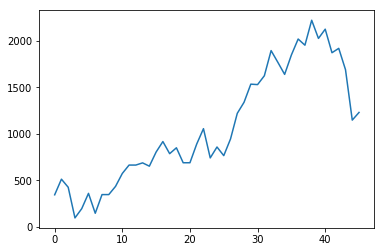

In [10]:
plt.plot(test_gain)

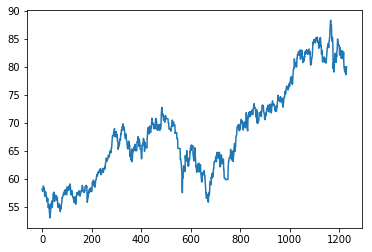

In [11]:
plt.plot(data_all['Close'])

In [12]:
#sqld.ratio_local_size

In [13]:
#sqld.last_w

In [14]:
import numpy
def plot_each_w_trend(choose_feature, w_list):
    wListTranspose = numpy.zeros(shape=(len(choose_feature), len(w_list)))

    for feature in range(0, len(choose_feature)):
        if choose_feature[feature]:
            print('w of feature num = ', feature)
            for trial in range(0, len(w_list)):
                wListTranspose[feature][trial] = w_list[trial][feature]
            plt.plot(wListTranspose[feature])
            plt.show()
            
            
plot_each_w_trend(choose_feature, sqld.last_w)

NameError: name 'sqld' is not defined

In [ ]:
import numpy
def plot_each_w_trend(choose_feature, w_list):
    wListTranspose = numpy.zeros(shape=(len(choose_feature), len(w_list)))

    for feature in range(0, len(choose_feature)):
        if choose_feature[feature]:
            print('feature num = ', feature)
            for trial in range(0, len(w_list)):
                wListTranspose[feature][trial] = w_list[trial][feature]
            print(wListTranspose[feature][:50])
            
plot_each_w_trend(choose_feature, sqld.last_w)

In [ ]:
start_date = (start_date + pd.DateOffset(days= 0)).date()
print(type(start_date))
start_date

In [ ]:
(data_all.index[data_all['Date'] == start_date])[0]

In [ ]:
(data_all.iloc[1180])['Date'].date() == start_date

In [ ]:
data_all['Date'][1]